<a href="https://colab.research.google.com/github/zacharyvunguyen/Skin-Cancer-Detection-with-Transfer-Learning-Deep-CNN/blob/main/01_Skin_Cancer_Classification_with_MobileNetV2_Model_Building_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [7]:
import pandas as pd
import seaborn as sns
#math operations
import numpy as np
#machine learning
import cv2                     
import os                  
from random import shuffle
from tqdm import tqdm  
import random
#for opening and loading image
import PIL
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

#Mounting Gdrive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Images in Directory

In [9]:
# setting path of directory
B_DIR = "/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/train/"
M_DIR =  "/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/train/"
N_DIR = "/content/drive/MyDrive/0_data_science/skin_cancer/Nevus/train/"


# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Bimages = os.listdir(B_DIR)
Mimages = os.listdir(M_DIR)
Nimages = os.listdir(N_DIR)

## Checking sample images

In [ ]:
def display_images_in_folder(img_directory,name,display_image_num):
  folder_num=len(os.listdir(img_directory))
  fig_w=display_image_num * 4
  fig_h=folder_num * 5
  fig, axs = plt.subplots(folder_num, display_image_num, figsize = (20, 10))
  count = 0
  for i in os.listdir(img_directory):
    # get the list of images in a given class
    train_class = os.listdir(os.path.join(img_directory, i))
    # plot  images per class
    for j in range(display_image_num):
      img = os.path.join(img_directory, i, train_class[j])
      img = PIL.Image.open(img)
      axs[count][j].title.set_text(f'{i} folder: {train_class[j]}')
      axs[count][j].imshow(img)  
    count += 1
  fig.suptitle(f'{name} sample images',fontsize=20)
  fig.tight_layout()

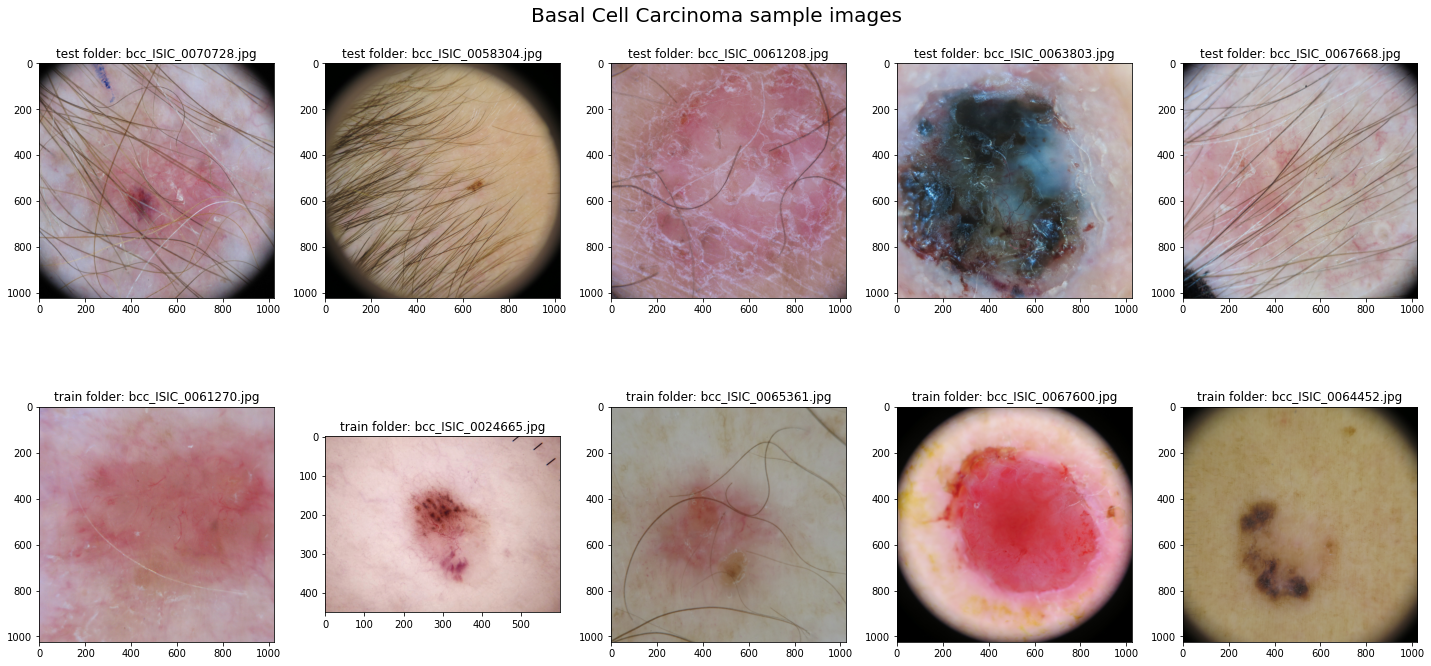

In [ ]:
display_images_in_folder(img_directory='/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma',name='Basal Cell Carcinoma',display_image_num=5)

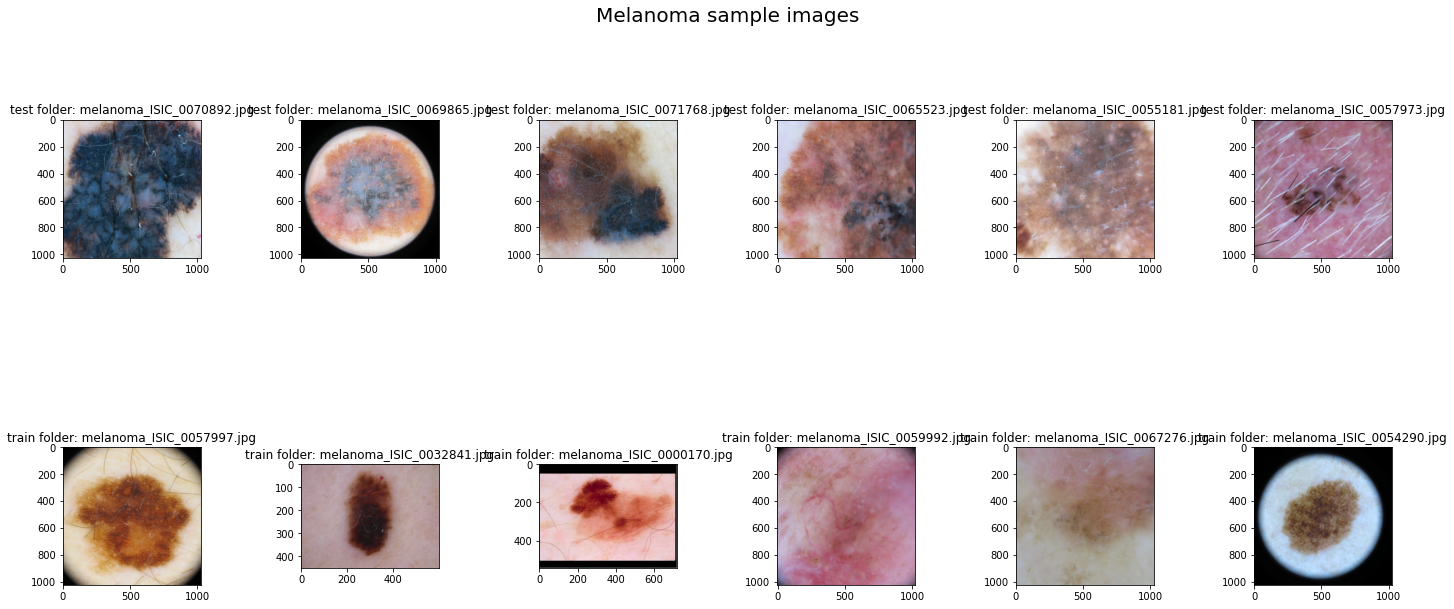

In [ ]:
display_images_in_folder(img_directory='/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma',name='Melanoma',display_image_num=6)

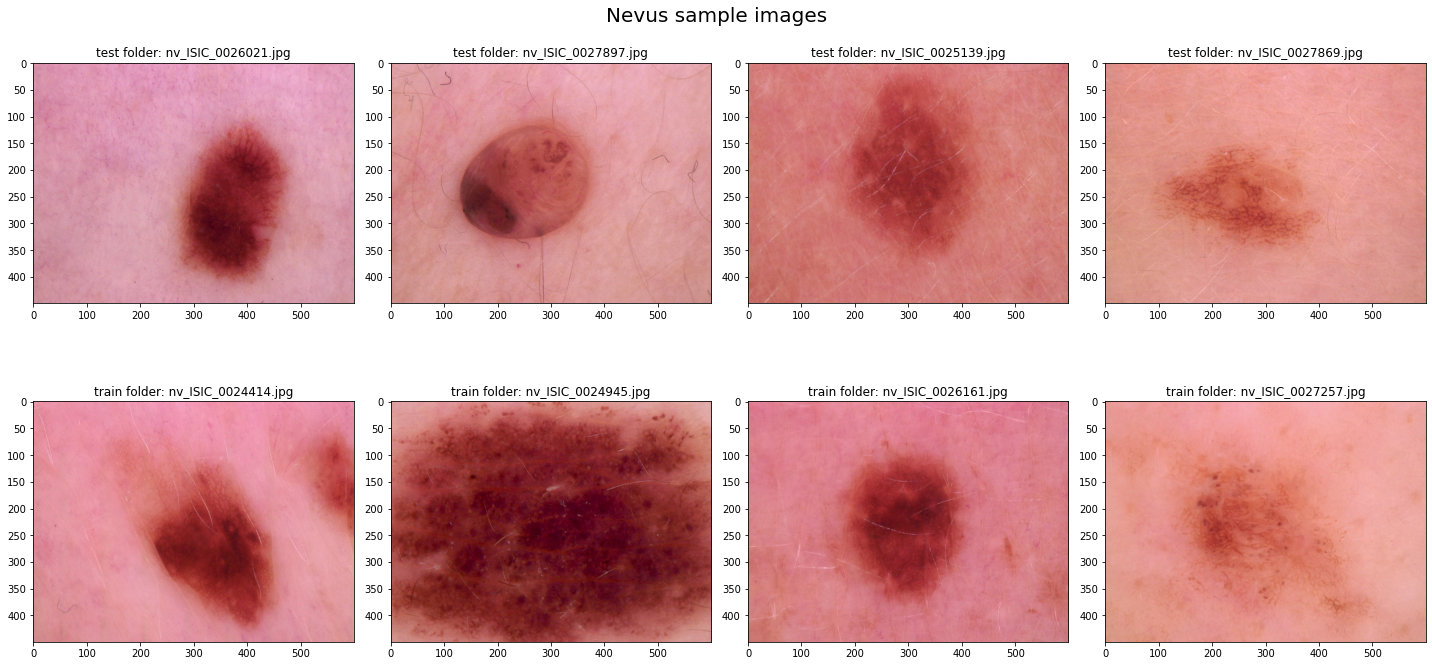

In [ ]:
display_images_in_folder(img_directory='/content/drive/MyDrive/0_data_science/skin_cancer/Nevus',name='Nevus',display_image_num=4)

## Data Preparation - Loading Images and Labels

In [10]:
print(B_DIR)
print(M_DIR)
print(N_DIR)

/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/train/
/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/train/
/content/drive/MyDrive/0_data_science/skin_cancer/Nevus/train/


In [ ]:
data=[]
labels=[]
Basal=os.listdir(B_DIR)
for a in Basal:
    try:
        image=cv2.imread(B_DIR+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir(M_DIR)
for b in Melanoma:
    try:
        image=cv2.imread(M_DIR+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir(N_DIR)
for c in Nevus:
    try:
        image=cv2.imread(N_DIR+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")


In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/MyDrive/0_data_science/skin_cancer/feats_train/train_features_v2.npy",feats)
np.save("/content/drive/MyDrive/0_data_science/skin_cancer/labels_train/train_labels_v2.npy",labels)

## Loading saved data and labels

In [11]:
feats=np.load("/content/drive/MyDrive/0_data_science/skin_cancer/feats_train/train_features.npy")
labels=np.load("/content/drive/MyDrive/0_data_science/skin_cancer/feats_train/train_labels.npy")

In [12]:
feats.shape

(12295, 224, 224, 3)

In [13]:
labels.shape

(12295,)

## Randomizing Data and Labels

In [14]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [15]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

12295


In [16]:
print(num_classes)

3


## Train Test Split

In [17]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

## Image Data Normalization

**Pixel Rescaling** <br>
*Since images are grayscale, all values are in the range of 0–255. We divide by 255 so that the pixel values lie between 0 and 1. This is a form of normalization, and will speed up our training process later.*

In [18]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [19]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

In [20]:
y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9836, 224, 224, 3)
(9836, 3)
(2459, 224, 224, 3)
(2459, 3)


### (Optional) Understand Images

In [6]:
##Read image
#image_path="/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/test/bcc_ISIC_0053474.jpg"
#img=cv2.imread(image_path,0)

#Now we have the image in img variable.
#To visualize the image we can use matplotlib.pyplot

#import matplotlib.pyplot as plt
#plt.imshow(img, cmap="gray")

In [ ]:
#number_arr = np.asarray(img)

#img_resized = cv2.resize(img, (224,224))

#print(np.asarray(img_resized))

[[2 1 1 ... 4 2 0]
 [3 3 1 ... 1 1 2]
 [1 2 1 ... 4 4 2]
 ...
 [9 7 9 ... 9 7 6]
 [4 7 6 ... 7 5 4]
 [9 3 6 ... 4 4 5]]


In [1]:
#plt.figure(figsize=(30,30))
#sns.heatmap(img_resized, annot= True, cmap="binary")

In [2]:
#img_resized = img_resized/255
#plt.figure(figsize=(30,30))
#sns.heatmap(img_resized, annot= True, cmap="binary")

In [3]:
#number_arr = np.asarray(img)

#img_resized = cv2.resize(img, (18,18))

#print(np.asarray(img_resized))

In [4]:
#plt.figure(figsize=(18,18))
#sns.heatmap(img_resized, annot= True, cmap="binary")

In [5]:
#img_resized = img_resized/255

#plt.figure(figsize=(20,20))
#sns.heatmap(img_resized, annot= True, cmap="binary")

## Image Augmentation

In [22]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

## Model Building

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

### Complie Model 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
BS = 64
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(x_train,y_train, batch_size=BS),
	steps_per_epoch=train_len // BS,
	validation_data=(x_test, y_test),
	validation_steps=test_len // BS,
	epochs=30,callbacks=callbacks)

[INFO] training head...
Epoch 1/30
153/153 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.7834
Epoch 1: val_loss improved from inf to 5.06893, saving model to .mdl_wts.hdf5
153/153 [==============================] - 111s 626ms/step - loss: 0.5232 - accuracy: 0.7834 - val_loss: 5.0689 - val_accuracy: 0.3928 - lr: 0.0010
Epoch 2/30
153/153 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8484
Epoch 2: val_loss did not improve from 5.06893
153/153 [==============================] - 90s 584ms/step - loss: 0.3886 - accuracy: 0.8484 - val_loss: 5.8057 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 3/30
153/153 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8723
Epoch 3: val_loss did not improve from 5.06893

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
153/153 [==============================] - 91s 590ms/step - loss: 0.3293 - accuracy: 0.8723 - val_loss: 5.4281 - val_accuracy: 0.5026 - lr: 0.00

## Saving and Loading Model

### Save trained model `sc_model_v1.h5`

In [ ]:
model = load_model('.mdl_wts.hdf5')
model.save('/content/drive/MyDrive/0_data_science/skin_cancer/skin_model/sc_model_v1.h5')


**Test Accuracy Score:**

In [23]:
model = load_model('/content/drive/MyDrive/0_data_science/skin_cancer/skin_model/sc_model_v1.h5')
# checking the accuracy 
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:', accuracy[1])

77/77 [==============================] - 14s 33ms/step - loss: 0.1098 - accuracy: 0.9780

 Test_Accuracy: 0.9780398607254028


In [25]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]

array([1.1652828e-11, 1.0000000e+00, 4.7437421e-10], dtype=float32)

### Generate Confusion Matrix

In [26]:
pred = np.argmax(rounded_predictions,axis=1)
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
BS=16

154/154 [==============================] - 2s 16ms/step


In [27]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis=1) 
# Convert validation observations to one hot vectors
rounded_labels=np.argmax(y_test, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

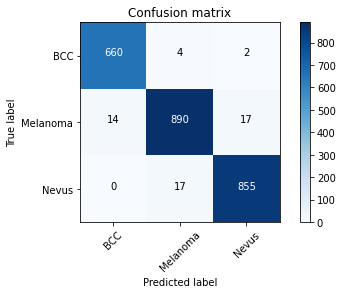

In [29]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [30]:
predIdxs = model.predict(x_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

# show a nicely formatted classification report
print(classification_report(rounded_labels, predIdxs,target_names=['BCC','Melanoma','Nevus']))

              precision    recall  f1-score   support

         BCC       0.98      0.99      0.99       666
    Melanoma       0.98      0.97      0.97       921
       Nevus       0.98      0.98      0.98       872

    accuracy                           0.98      2459
   macro avg       0.98      0.98      0.98      2459
weighted avg       0.98      0.98      0.98      2459



# Plotting ROC AUC

In [31]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

154/154 [==============================] - 2s 16ms/step


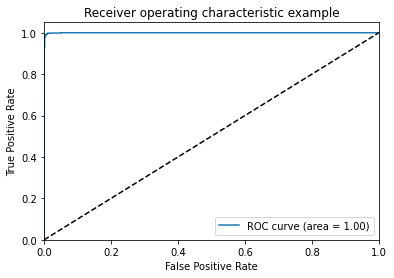

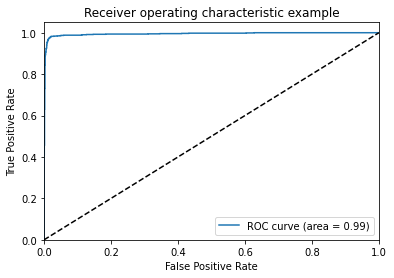

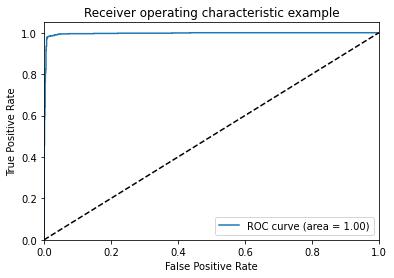

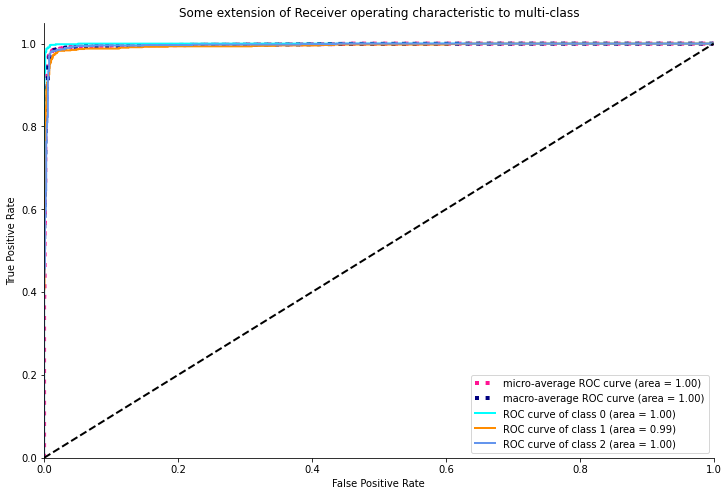

In [32]:
y_test = np.array(y_test)

n_classes = 3

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# Preparing Test Data

In [33]:
test_B='/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/test/'
test_M='/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/test/'
test_N='/content/drive/MyDrive/0_data_science/skin_cancer/Nevus/test/'
print(f'Basal cell carcinoma test directory: {test_B}')
print(f'Melanoma test directory: {test_M}')
print(f'Nevus test directory: {test_N}')

Basal cell carcinoma test directory: /content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/test/
Melanoma test directory: /content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/test/
Nevus test directory: /content/drive/MyDrive/0_data_science/skin_cancer/Nevus/test/


In [34]:
data=[]
labels=[]
Basal=os.listdir(test_B)
for a in Basal:
    try:
        image=cv2.imread(test_B+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir(test_M)
for b in Melanoma:
    try:
        image=cv2.imread(test_M+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir(test_N)
for c in Nevus:
    try:
        image=cv2.imread(test_N+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

Save .npy file

In [35]:
feats_test=np.array(data)
labels_test=np.array(labels)

np.save("/content/drive/MyDrive/0_data_science/skin_cancer/feats_test/feats_test.npy",feats_test)
np.save("/content/drive/MyDrive/0_data_science/skin_cancer/labels_test/labels_test.npy",labels_test)

Load .npy file

In [38]:
feats_test=np.load("/content/drive/MyDrive/0_data_science/skin_cancer/feats_test/feats_test.npy")
labels_test=np.load("/content/drive/MyDrive/0_data_science/skin_cancer/labels_test/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

150


In [39]:
x_valid = feats_test.astype('float32')/255
y_valid=to_categorical(labels_test,3)

In [40]:
print(x_valid.shape)
print(y_valid.shape)

(150, 224, 224, 3)
(150, 3)


In [41]:
pred_Y = model.predict(x_valid, batch_size = 10, verbose = True)
rounded_predictions = model.predict(x_valid, batch_size=16, verbose=0)
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_valid, axis=1)
BS=10

15/15 [==============================] - 1s 13ms/step


In [42]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_valid, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis=1) 
# Convert validation observations to one hot vectors
rounded_labels=np.argmax(y_valid, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


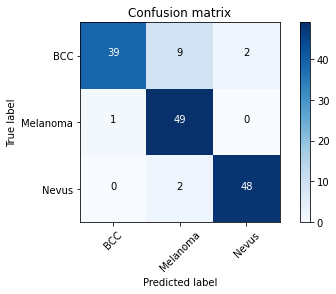

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

### Testing Images

In [44]:
model = load_model('/content/drive/MyDrive/0_data_science/skin_cancer/skin_model/sc_model_v1.h5')

In [45]:
img1 = "/content/drive/MyDrive/0_data_science/skin_cancer/Nevus/test/nv_ISIC_0027897.jpg"
img2 ="/content/drive/MyDrive/0_data_science/skin_cancer/Melanoma/test/melanoma_ISIC_0066319.jpg"
img3 = "/content/drive/MyDrive/0_data_science/skin_cancer/Basal_cell_carcinoma/test/bcc_ISIC_0060625.jpg"

In [46]:
class_dict ={0:"Basal_Cell_Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [47]:
from keras.preprocessing.image import img_to_array
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )
  
  return prediction

In [ ]:
from IPython.display import  display
def pred_image1(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]
  
  return pred_cat
    

In [48]:
pred_image(img1,model)

[('Nevus (Non-Cancerous)', 93.27),
 ('Melanoma (Cancer)', 6.57),
 ('Basal_Cell_Carcinoma (Cancer)', 0.16)]

In [49]:
pred_image(img2,model)

[('Melanoma (Cancer)', 100.0),
 ('Basal_Cell_Carcinoma (Cancer)', 0.0),
 ('Nevus (Non-Cancerous)', 0.0)]

In [50]:
pred_image(img3,model)

[('Basal_Cell_Carcinoma (Cancer)', 89.11),
 ('Melanoma (Cancer)', 10.29),
 ('Nevus (Non-Cancerous)', 0.6)]

# Plotting Sample Predictions

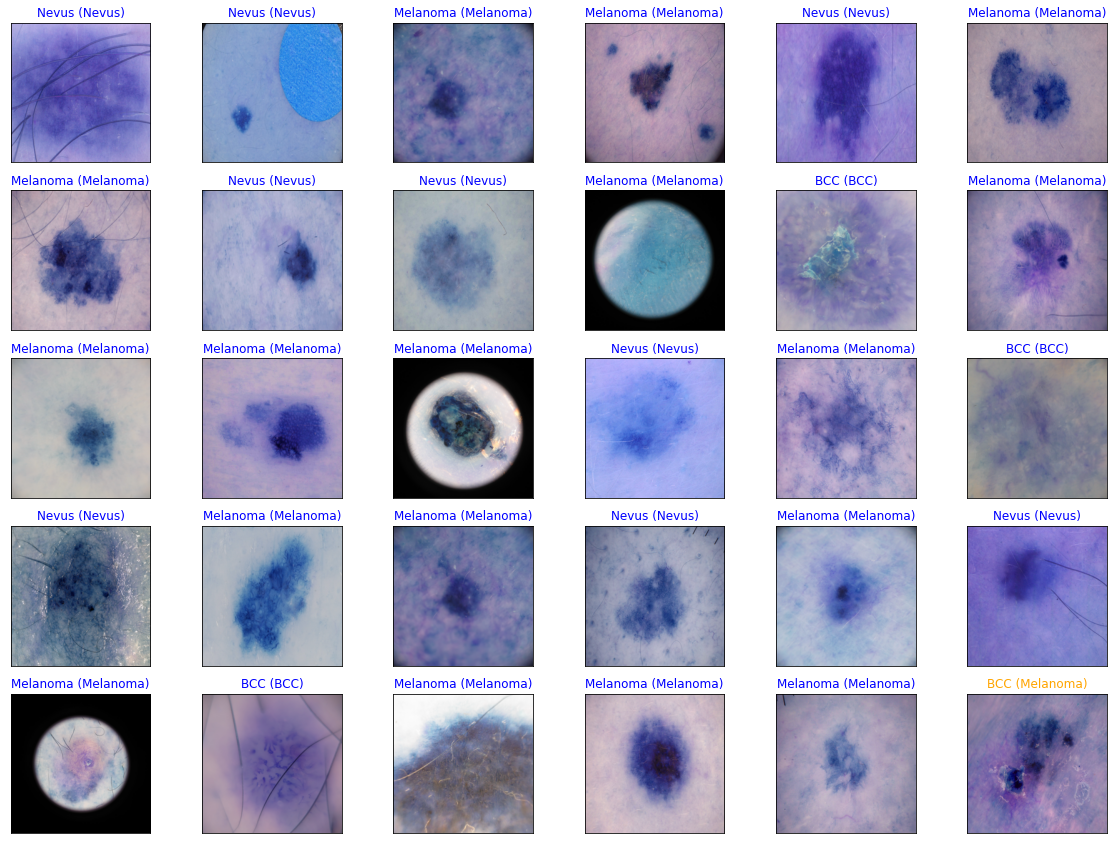

In [51]:
y_hat = model.predict(x_test)

# define text labels 
skin_labels = ['BCC','Melanoma','Nevus']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=30, replace=False)):
    ax = fig.add_subplot(6,6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))